# Recommendations with IBM


## Table of Contents

I. [Exploratory Data Analysis](#Exploratory-Data-Analysis)<br>
II. [Rank Based Recommendations](#Rank)<br>
III. [User-User Based Collaborative Filtering](#User-User)<br>
IV. [Matrix Factorization](#Matrix-Fact)<br>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
from scipy.stats import pearsonr 
%matplotlib inline

df = pd.read_csv('data/user-item-interactions.csv')
df_content = pd.read_csv('data/articles_community.csv')
del df['Unnamed: 0']
del df_content['Unnamed: 0']

# Show df to get an idea of the data
df.head()

,article_id,title,email
0,1430.0,"using pixiedust for fast, flexible, and easier...",ef5f11f77ba020cd36e1105a00ab868bbdbf7fe7
1,1314.0,healthcare python streaming application demo,083cbdfa93c8444beaa4c5f5e0f5f9198e4f9e0b
2,1429.0,use deep learning for image classification,b96a4f2e92d8572034b1e9b28f9ac673765cd074
3,1338.0,ml optimization using cognitive assistant,06485706b34a5c9bf2a0ecdac41daf7e7654ceb7
4,1276.0,deploy your python model as a restful api,f01220c46fc92c6e6b161b1849de11faacd7ccb2


In [2]:
df.shape

(45993, 3)

In [3]:
# Show df_content to get an idea of the data
df_content.head()

,doc_body,doc_description,doc_full_name,doc_status,article_id
0,Skip navigation Sign in SearchLoading...\r\n\r...,Detect bad readings in real time using Python ...,Detect Malfunctioning IoT Sensors with Streami...,Live,0
1,No Free Hunch Navigation * kaggle.com\r\n\r\n ...,"See the forest, see the trees. Here lies the c...",Communicating data science: A guide to present...,Live,1
2,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...,Here’s this week’s news in Data Science and Bi...,"This Week in Data Science (April 18, 2017)",Live,2
3,"DATALAYER: HIGH THROUGHPUT, LOW LATENCY AT SCA...",Learn how distributed DBs solve the problem of...,DataLayer Conference: Boost the performance of...,Live,3
4,Skip navigation Sign in SearchLoading...\r\n\r...,This video demonstrates the power of IBM DataS...,Analyze NY Restaurant data using Spark in DSX,Live,4


### <a class="anchor" id="Exploratory-Data-Analysis">Part I : Exploratory Data Analysis</a>

In [4]:
df.article_id.nunique()

714

In [5]:
df.email.nunique()

5148

In [6]:
df_content.shape

(1056, 5)

In [7]:
df.head()

,article_id,title,email
0,1430.0,"using pixiedust for fast, flexible, and easier...",ef5f11f77ba020cd36e1105a00ab868bbdbf7fe7
1,1314.0,healthcare python streaming application demo,083cbdfa93c8444beaa4c5f5e0f5f9198e4f9e0b
2,1429.0,use deep learning for image classification,b96a4f2e92d8572034b1e9b28f9ac673765cd074
3,1338.0,ml optimization using cognitive assistant,06485706b34a5c9bf2a0ecdac41daf7e7654ceb7
4,1276.0,deploy your python model as a restful api,f01220c46fc92c6e6b161b1849de11faacd7ccb2


In [8]:
median_val = df.groupby('email')['article_id'].count().median()
max_views_by_user = df.groupby('email')['article_id'].count().max()

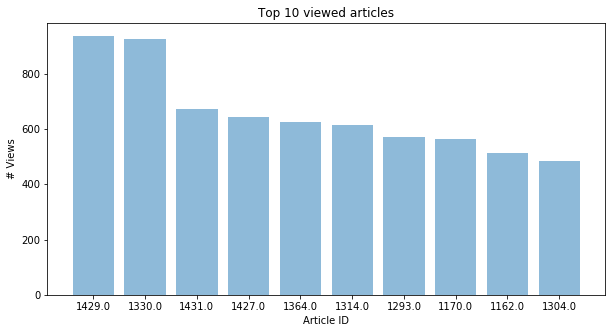

In [9]:
values = df.groupby('article_id')['email'].count().sort_values(ascending=False).values[:10]
index = df.groupby('article_id')['email'].count().sort_values(ascending=False).index[:10]

y_pos = np.arange(len(index))
plt.figure(figsize=(10,5))
plt.bar(y_pos[:10], values[:10],alpha=0.5,)
plt.xticks(y_pos, labels = index[:10])
plt.xlabel('Article ID')
plt.ylabel('# Views')

plt.title('Top 10 viewed articles')
plt.show();

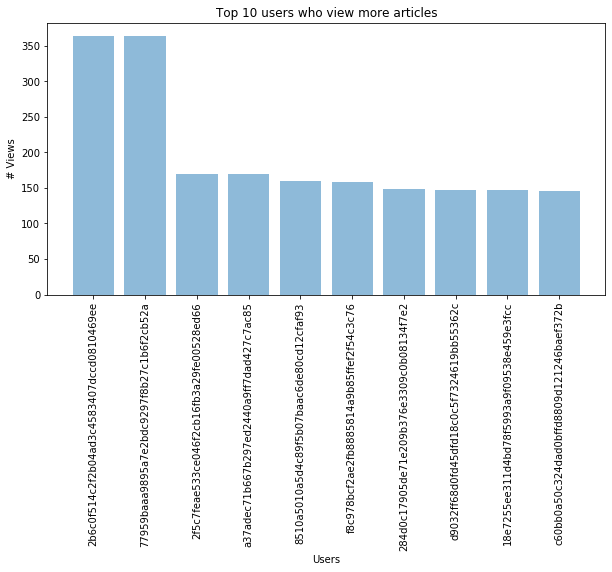

In [10]:
values = df.groupby('email')['article_id'].count().sort_values(ascending=False).values[:10]
index = df.groupby('email')['article_id'].count().sort_values(ascending=False).index[:10]

y_pos = np.arange(len(index))
plt.figure(figsize=(10,5))
plt.bar(y_pos[:10], values[:10],alpha=0.5,)
plt.xticks(y_pos, labels = index[:10], rotation=90)
plt.xlabel('Users')
plt.ylabel('# Views')

plt.title('Top 10 users who view more articles')
plt.show();

Exploring and removing duplicate articles from the **df_content** dataframe.  

In [11]:
df_content.article_id[df_content.article_id.duplicated()]

365     50
692    221
761    398
970    577
971    232
Name: article_id, dtype: int64

In [12]:
df_content = df_content.drop_duplicates('article_id', keep='first')

In [13]:
df_content.shape

(1051, 5)

In [14]:
df.email.nunique()

5148

In [15]:
df.groupby('article_id')['email'].count().sort_values(ascending=False)

article_id
1429.0    937
1330.0    927
1431.0    671
1427.0    643
1364.0    627
1314.0    614
1293.0    572
1170.0    565
1162.0    512
1304.0    483
1436.0    481
1271.0    473
1398.0    465
43.0      460
1351.0    457
1393.0    454
1185.0    442
1160.0    433
1354.0    426
1368.0    418
1305.0    413
1338.0    382
1336.0    379
1165.0    372
1172.0    363
151.0     352
1276.0    347
1432.0    340
1430.0    336
1052.0    330
         ... 
1210.0      2
1226.0      2
1227.0      2
1067.0      2
1230.0      2
1137.0      2
1135.0      2
1235.0      2
1251.0      2
364.0       2
1130.0      2
1244.0      2
1127.0      1
675.0       1
1119.0      1
653.0       1
662.0       1
974.0       1
1344.0      1
1113.0      1
724.0       1
1072.0      1
1266.0      1
1200.0      1
1202.0      1
1233.0      1
1237.0      1
417.0       1
984.0       1
1092.0      1
Name: email, Length: 714, dtype: int64

In [16]:
unique_articles = df.article_id.nunique() # The number of unique articles that have at least one interaction
total_articles = df_content.article_id.nunique()# The number of unique articles on the IBM platform
unique_users = df.email.nunique() # The number of unique users

user_article_interactions = df.shape[0]# The number of user-article interactions


In [17]:
df.groupby('article_id')['email'].count().sort_values().tail(1).values[0]

937

In [18]:
df.groupby('article_id')['email'].count().sort_values().tail(1).index[0]

1429.0

In [19]:
most_viewed_article_id = str(df.groupby('article_id')['email'].count().sort_values().tail(1).index[0])# The most viewed article in the dataset as a string with one value following the decimal 
max_views = df.groupby('article_id')['email'].count().sort_values().tail(1).values[0]# The most viewed article in the dataset was viewed how many times?

In [20]:
def email_mapper():
    coded_dict = dict()
    cter = 1
    email_encoded = []
    
    for val in df['email']:
        if val not in coded_dict:
            coded_dict[val] = cter
            cter+=1
        
        email_encoded.append(coded_dict[val])
    return email_encoded

email_encoded = email_mapper()
del df['email']
df['user_id'] = email_encoded

# show header
df.head()

,article_id,title,user_id
0,1430.0,"using pixiedust for fast, flexible, and easier...",1
1,1314.0,healthcare python streaming application demo,2
2,1429.0,use deep learning for image classification,3
3,1338.0,ml optimization using cognitive assistant,4
4,1276.0,deploy your python model as a restful api,5


In [21]:
df.groupby('title')['title'].count().sort_values(ascending=False)

title
use deep learning for image classification                                            937
insights from new york car accident reports                                           927
visualize car data with brunel                                                        671
use xgboost, scikit-learn & ibm watson machine learning apis                          643
predicting churn with the spss random tree algorithm                                  627
healthcare python streaming application demo                                          614
finding optimal locations of new store using decision optimization                    572
apache spark lab, part 1: basic concepts                                              565
analyze energy consumption in buildings                                               512
gosales transactions for logistic regression model                                    483
welcome to pixiedust                                                                  481
cust

In [22]:
df.head()

,article_id,title,user_id
0,1430.0,"using pixiedust for fast, flexible, and easier...",1
1,1314.0,healthcare python streaming application demo,2
2,1429.0,use deep learning for image classification,3
3,1338.0,ml optimization using cognitive assistant,4
4,1276.0,deploy your python model as a restful api,5


In [23]:
def get_top_articles(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    top_articles = list(df.groupby('title')['title'].count().sort_values(ascending=False).index[:n])
    
    
    return top_articles # Return the top article titles from df (not df_content)

def get_top_article_ids(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    top_articles = list(str(n) for n in df.groupby('article_id')['article_id'].count().sort_values(ascending=False).index[:n])
    
    return top_articles # Return the top article ids

In [24]:
print(get_top_articles(10))
print(get_top_article_ids(10))

['use deep learning for image classification', 'insights from new york car accident reports', 'visualize car data with brunel', 'use xgboost, scikit-learn & ibm watson machine learning apis', 'predicting churn with the spss random tree algorithm', 'healthcare python streaming application demo', 'finding optimal locations of new store using decision optimization', 'apache spark lab, part 1: basic concepts', 'analyze energy consumption in buildings', 'gosales transactions for logistic regression model']
['1429.0', '1330.0', '1431.0', '1427.0', '1364.0', '1314.0', '1293.0', '1170.0', '1162.0', '1304.0']


In [25]:
top_5 = get_top_articles(5)
top_10 = get_top_articles(10)
top_20 = get_top_articles(20)

In [26]:
top_10

['use deep learning for image classification',
 'insights from new york car accident reports',
 'visualize car data with brunel',
 'use xgboost, scikit-learn & ibm watson machine learning apis',
 'predicting churn with the spss random tree algorithm',
 'healthcare python streaming application demo',
 'finding optimal locations of new store using decision optimization',
 'apache spark lab, part 1: basic concepts',
 'analyze energy consumption in buildings',
 'gosales transactions for logistic regression model']

### <a class="anchor" id="User-User">Part III: User-User Based Collaborative Filtering</a>

In [27]:
# create the user-article matrix with 1's and 0's

def create_user_item_matrix(df):
    '''
    INPUT:
    df - pandas dataframe with article_id, title, user_id columns
    
    OUTPUT:
    user_item - user item matrix 
    
    Description:
    Return a matrix with user ids as rows and article ids on the columns with 1 values where a user interacted with 
    an article and a 0 otherwise
    '''
    # Fill in the function here
    _df = df.copy()
    _df.drop_duplicates(inplace=True)
    _df['1'] = 1
    
    user_item = _df.pivot(index='user_id', columns='article_id', values='1').fillna(0)
    
    return user_item # return the user_item matrix 

user_item = create_user_item_matrix(df)

In [28]:
user_item.shape[0]

5149

In [29]:
user_item.sum(axis=1)[1]

36.0

In [30]:
def find_similar_users(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user_id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    similar_users - (list) an ordered list where the closest users (largest dot product users)
                    are listed first
    
    Description:
    Computes the similarity of every pair of users based on the dot product
    Returns an ordered
    
    '''

    v1 = user_item.loc[int(user_id),:]

    sims = [np.where(np.isnan(v1),0,v1).dot(np.where(np.isnan(user_item.loc[int(n),:]),0,user_item.loc[int(n),:])) 
            for n in user_item.index]

    users = user_item.index

    user_sims_df = pd.Series(sims, index=users).T
    user_sims_df = user_sims_df.sort_values(ascending=False)
    user_sims_df.drop(index=user_id, inplace=True)
    most_similar_users = list(user_sims_df.index)
       
    return most_similar_users # return a list of the users in order from most to least similar
        

In [31]:
print("The 10 most similar users to user 1 are: {}".format(find_similar_users(1)[:10]))
print("The 5 most similar users to user 3933 are: {}".format(find_similar_users(3933)[:5]))
print("The 3 most similar users to user 46 are: {}".format(find_similar_users(46)[:3]))

The 10 most similar users to user 1 are: [3933, 23, 3782, 203, 4459, 131, 3870, 46, 4201, 5041]
The 5 most similar users to user 3933 are: [1, 23, 3782, 4459, 203]
The 3 most similar users to user 46 are: [4201, 23, 3782]


In [32]:
df_content.head()

,doc_body,doc_description,doc_full_name,doc_status,article_id
0,Skip navigation Sign in SearchLoading...\r\n\r...,Detect bad readings in real time using Python ...,Detect Malfunctioning IoT Sensors with Streami...,Live,0
1,No Free Hunch Navigation * kaggle.com\r\n\r\n ...,"See the forest, see the trees. Here lies the c...",Communicating data science: A guide to present...,Live,1
2,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...,Here’s this week’s news in Data Science and Bi...,"This Week in Data Science (April 18, 2017)",Live,2
3,"DATALAYER: HIGH THROUGHPUT, LOW LATENCY AT SCA...",Learn how distributed DBs solve the problem of...,DataLayer Conference: Boost the performance of...,Live,3
4,Skip navigation Sign in SearchLoading...\r\n\r...,This video demonstrates the power of IBM DataS...,Analyze NY Restaurant data using Spark in DSX,Live,4


In [33]:
def get_article_names(article_ids, df=df):
    '''
    INPUT:
    article_ids - (list) a list of article ids
    df - (pandas dataframe) df as defined at the top of the notebook
    
    OUTPUT:
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the title column)
    '''
    
    article_names = [df.loc[df['article_id'] == float(i), 'title'].unique()[0] for i in article_ids]

    
    return article_names # Return the article names associated with list of article ids


def get_user_articles(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    article_ids - (list) a list of the article ids seen by the user
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the doc_full_name column in df_content)
    
    Description:
    Provides a list of the article_ids and article titles that have been seen by a user
    '''
    
    
    article_ids = [str(i) for i in user_item.loc[user_id,:][user_item.loc[user_id,:] == 1].index]
    article_names = get_article_names(article_ids)
    
    return article_ids, article_names # return the ids and names

def user_user_recs(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    Users who are the same closeness are chosen arbitrarily as the 'next' user
    
    For the user where the number of recommended articles starts below m 
    and ends exceeding m, the last items are chosen arbitrarily
    
    '''
    user_articles = get_user_articles(user_id, user_item=user_item)
    similar_users = find_similar_users(user_id, user_item=user_item)
    
    recs = []
    for user in similar_users:
        checking = get_user_articles(user, user_item=user_item)[0]
        for rec in checking:
            if (rec not in user_articles) & (rec not in recs) & (len(recs) < m):
                recs.append(rec)
            else:
                break

    return  recs # return your recommendations for this user_id    

In [34]:
# Check Results
get_article_names(user_user_recs(1, 10)) # Return 10 recommendations for user 1

['deep learning with tensorflow course by big data university',
 'tensorflow quick tips',
 'sector correlations shiny app',
 'time series prediction using recurrent neural networks (lstms)',
 'introduction to market basket analysis in\xa0python',
 'fighting gerrymandering: using data science to draw fairer congressional districts',
 'introducing ibm watson studio ',
 'python for loops explained (python for data science basics #5)',
 'new shiny cheat sheet and video tutorial',
 'tidyverse practice: mapping large european cities']

In [35]:
get_article_names(['1320.0', '232.0', '844.0'])

['housing (2015): united states demographic measures',
 'self-service data preparation with ibm data refinery',
 'use the cloudant-spark connector in python notebook']

In [36]:
get_user_articles(20)[0]

['232.0', '844.0', '1320.0']

In [37]:
get_user_articles(2)[0]

['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0']

In [38]:
def get_top_sorted_users(user_id, df=df, user_item=user_item):
    '''
    INPUT:
    user_id - (int)
    df - (pandas dataframe) df as defined at the top of the notebook 
    user_item - (pandas dataframe) matrix of users by articles: 
            1's when a user has interacted with an article, 0 otherwise
    
            
    OUTPUT:
    neighbors_df - (pandas dataframe) a dataframe with:
                    neighbor_id - is a neighbor user_id
                    similarity - measure of the similarity of each user to the provided user_id
                    num_interactions - the number of articles viewed by the user - if a u
                    
    Other Details - sort the neighbors_df by the similarity and then by number of interactions where 
                    highest of each is higher in the dataframe
     
    '''
    neighbor_id = find_similar_users(user_id, user_item=user_item)
    
    v1 = user_item.loc[int(user_id),:]
    similarity = [np.where(np.isnan(v1),0,v1).dot(np.where(np.isnan(user_item.loc[int(n),:]),0,user_item.loc[int(n),:])) 
            for n in user_item.index if n != user_id]
    
    num_interactions = [user_item.loc[n,:].sum() for n in user_item.index if n != user_id]
    
    neighbors_df= pd.DataFrame([neighbor_id, similarity, num_interactions]).T
    
    neighbors_df.columns = ['neighbor_id', 'similarity', 'num_interactions']
    neighbors_df.sort_values(by=['similarity', 'num_interactions'], ascending=False, inplace=True)
    
    return neighbors_df


def user_user_recs_part2(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user by article id
    rec_names - (list) a list of recommendations for the user by article title
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    * Choose the users that have the most total article interactions 
    before choosing those with fewer article interactions.

    * Choose articles with the articles with the most total interactions 
    before choosing those with fewer total interactions. 
   
    '''
    user_articles = get_user_articles(user_id, user_item=user_item)
    similar_users = get_top_sorted_users(user_id, df=df, user_item=user_item)
    
    recs = []
    for user in similar_users.neighbor_id:
        checking = get_user_articles(user, user_item=user_item)[0]
        for rec in checking:
            if (rec not in user_articles) & (rec not in recs) & (len(recs) < m):
                recs.append(rec)
            else:
                break
    
    rec_names = get_article_names(recs)
    return recs, rec_names

In [39]:
user_user_recs_part2(10, m=10)

(['60.0',
  '566.0',
  '1367.0',
  '20.0',
  '43.0',
  '57.0',
  '98.0',
  '116.0',
  '124.0',
  '125.0'],
 ['readr 1.0.0',
  'the t-distribution: a key statistical concept discovered by a beer brewery',
  'programmatic evaluation using watson conversation',
  'working interactively with rstudio and notebooks in dsx',
  'deep learning with tensorflow course by big data university',
  'transfer learning for flight delay prediction via variational autoencoders',
  'how to map usa rivers using ggplot2',
  'practical tutorial on random forest and parameter tuning in r',
  'python machine learning: scikit-learn tutorial',
  'statistics for hackers'])

In [40]:
rec_ids, rec_names = user_user_recs_part2(20, 10)
print("The top 10 recommendations for user 20 are the following article ids:")
print(rec_ids)
print()
print("The top 10 recommendations for user 20 are the following article names:")
print(rec_names)

The top 10 recommendations for user 20 are the following article ids:
['566.0', '1052.0', '1183.0', '1320.0', '1174.0', '1181.0', '1271.0', '1281.0', '109.0', '138.0']

The top 10 recommendations for user 20 are the following article names:
['the t-distribution: a key statistical concept discovered by a beer brewery', 'access db2 warehouse on cloud and db2 with python', 'categorize urban density', 'housing (2015): united states demographic measures', 'breast cancer wisconsin (diagnostic) data set', 'car performance data', 'customer demographics and sales', 'electric power consumption (kwh per capita) by country', 'tensorflow quick tips', 'best packages for data manipulation in r']


In [41]:
### Tests with a dictionary of results

user1_most_sim = find_similar_users(1)[:1]# Find the user that is most similar to user 1 
user131_10th_sim = find_similar_users(131)[9:10]# Find the 10th most similar user to user 131

In [42]:
user1_most_sim

[3933]

### <a class="anchor" id="Matrix-Fact">Part IV: Matrix Factorization</a>

Build use matrix factorization to make article recommendations to the users on the IBM Watson Studio platform.

In [43]:
# Loading the matrix
user_item_matrix = pd.read_pickle('user_item_matrix.p')

In [44]:
# quick look at the matrix
user_item_matrix.head()

article_id,0.0,100.0,1000.0,1004.0,1006.0,1008.0,101.0,1014.0,1015.0,1016.0,...,977.0,98.0,981.0,984.0,985.0,986.0,990.0,993.0,996.0,997.0
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [45]:
# SVD on the User-Item Matrix Here

u, s, vt = np.linalg.svd(user_item_matrix)

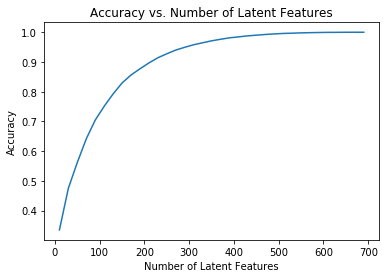

In [46]:
num_latent_feats = np.arange(10,700+10,20)
sum_errs = []

for k in num_latent_feats:
    # restructure with k latent features
    s_new, u_new, vt_new = np.diag(s[:k]), u[:, :k], vt[:k, :]
    
    # take dot product
    user_item_est = np.around(np.dot(np.dot(u_new, s_new), vt_new))
    
    # compute error for each prediction to actual value
    diffs = np.subtract(user_item_matrix, user_item_est)
    
    # total errors and keep track of them
    err = np.sum(np.sum(np.abs(diffs)))
    sum_errs.append(err)
    
    
plt.plot(num_latent_feats, 1 - np.array(sum_errs)/df.shape[0]);
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.title('Accuracy vs. Number of Latent Features');

In [47]:
df_train = df.head(40000)
df_test = df.tail(5993)

def create_test_and_train_user_item(df_train, df_test):
    '''
    INPUT:
    df_train - training dataframe
    df_test - test dataframe
    
    OUTPUT:
    user_item_train - a user-item matrix of the training dataframe 
                      (unique users for each row and unique articles for each column)
    user_item_test - a user-item matrix of the testing dataframe 
                    (unique users for each row and unique articles for each column)
    test_idx - all of the test user ids
    test_arts - all of the test article ids
    
    '''
    _df_train = df_train.copy()
    _df_test = df_test.copy()

    _df_train.drop_duplicates(inplace=True)
    _df_test.drop_duplicates(inplace=True)
    
    _df_train['1'] = 1
    _df_test['1'] = 1
    
    user_item_train = create_user_item_matrix(_df_train)
    user_item_test = create_user_item_matrix(_df_test)
    
    test_idx = user_item_test.index.values
    test_arts = user_item_test.columns
    
    
    
    return user_item_train, user_item_test, test_idx, test_arts

user_item_train, user_item_test, test_idx, test_arts = create_test_and_train_user_item(df_train, df_test)

In [48]:
u_train, s_train, vt_train = np.linalg.svd(user_item_train)  # fit svd similar to above then use the cells below


In [49]:
common_ids = list(np.unique([i for i in df_train.user_id.values if i in df_test.user_id.values]))

# Articles train dataset
articles_train = user_item_train.columns.map(int)
articles_id_list = np.where(np.in1d(articles_train, np.intersect1d(test_arts.map(int), articles_train)))[0] 

# Subset test dataset
user_item_test_subset = user_item_test[user_item_test.index.get_level_values(0).isin(common_ids)]

In [50]:
num_latent_feats = np.arange(0, len(articles_id_list), 20)
sum_errs = []

for k in num_latent_feats:
    
    # Train
    s_train_k, u_train_k, vt_train_k = np.diag(s_train[:k]), u_train[:, :k], vt_train[:k, :]
    
    # Test
    s_test_k, u_test_k, vt_test_k = s_train_k, u_train_k[list(map(lambda i: i - 1, common_ids)),:], vt_train_k[:,articles_id_list]
    
    # take dot product
    user_item_test_subset_est = np.around(np.dot(np.dot(u_test_k, s_test_k), vt_test_k))
    
    # compute error for each prediction to actual value
    diffs = np.subtract(user_item_test_subset, user_item_test_subset_est)
    
    # total errors and keep track of them
    err = np.sum(np.sum(np.abs(diffs)))
    sum_errs.append(err)

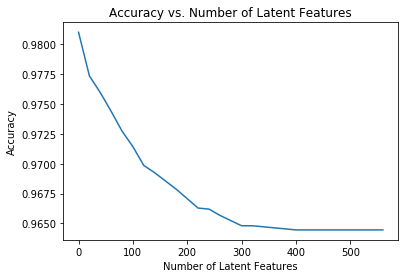

In [51]:
plt.plot(num_latent_feats, 1 - np.array(sum_errs) /  (len(user_item_test_subset) * len(user_item_test_subset.columns)));
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.title('Accuracy vs. Number of Latent Features');